# Documentation of on-going work

###### Author : Ishaan Bhat


This work seeks to develop a model that can reconstruct the entire data sample when presented with  partial or noisy instance of that sample. Initial work was pivoted towards creating a generative model that would be trained together with a discriminator (classifier), i.e. a [Generative Adversarial Network (GAN) developed by Goodfellow et al](http://arxiv.org/abs/1701.00160).

In the first phase of the work, efforts were directed to develop a classifier for the CIFAR-10 image data set. The motivation behind this was to be famililar with Tensorflow, CNN architectures, generalization and optimization techniques. 

### Convolutional Neural Networks:

Fully connected neural networks do not scale well with the size of the image due to the large number of parameters that would be required for such a model. CNNs seek to solve this problem by using parameter sharing which exploits the inherent structure present in images. This is done by performing convolution of the input image with a set of *kernels* or *filters* to generate of set of *feature maps*. Each feature map is created as a result of the convolution between the image and a single kernel, thus each feature map uses the same set of parameters. The filter co-efficients are trainable variables, the filter size (local receptive field) and the number of filters are hyper-parameters. Each filter has width and height dimensions considerably smaller than the image dimensions. The depth of the filter is equal to the number of image channels. Each convolution creates a 2-D feature map, a set of filters create of 3-D volume with the depth equal to the number of filters chosen. [Width and height can analysed as follows.](http://cs231n.github.io/convolutional-networks/#conv). Intuitively, it can be seen that each feature map shows us whether the feature the corresponding filter is trained to observe is present in a certain location in the image. The convolution operation is translationally invariant i.e. a certain feature if present in the image will be detected irrespective of its location within the image. 
    
The CNN can be decomposed into the following building blocks:

* **Convolution Layer**:

    
By setting the filter width and height dimensions, we define the *receptive field* for each neuron in the feature map. Thus each neuron with a single feature map reacts to a very small part of the image, thus a feature map would encode only very local features of the input it is fed. 
    
* **Pooling and Normalizing Layer**:

A pooling layer is usually inserted between 2 consecutive convolution layers. The pooling operation takes the maximum over a fixed 2-D window given a feature map. It operates independently on each depth slice of the feature volume. By downsampling the feature map, the convolution in the next stage would be trained to detect higher level features since the *effective local receptive feild* of this next convolution w.r.t. the input image has increased in size.

* **Fully Connected Layer**:

After multiple convolution and pooling layers (optionally normalization layers), the output (or readout) layer is usually fully connected to the preceding layer. There can also be multiple fully connected layers. An interesting insight about this layer is that we can imagine the stacked conv layers as reducing the input image to a point in a space of high-level or abstract features. The FC layer(s) learn a non-linear function to perform classification in this space([source](https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns)).


### CIFAR-10 Classifier

The model is developed based on [TensorFlow documentation](https://www.tensorflow.org/tutorials/deep_cnn) and the [associated code](https://github.com/tensorflow/models/tree/master/tutorials/image/cifar10). Code developed by the author can be found [here](https://github.com/kilgore92/cifarCNN).


The model has the following architecture:

**INPUT -> [CONV -> RELU -> POOL]x2->[FC]x2->OUTPUT**

The feature maps have a receptive field of 5x5 (and a stride of 1) with 64 maps generated for each convolution layer. The pooling layers use max pooling with a window size of 3x3 (with stride of 2). The output is a vector of size of 10, each element denoting the probability of the class being equal to its index. 

The baseline version of the code uses L2 weight regularization and augments input images by adding various types of noise. For the baseline version, an accuracy of 86.6% was obtained.

**TODO : Add graph**

The model was adapted to use various new architectural changes/optimizations such as Dropout and Batch Normalization. Techniques like adversarial traning were studied but not implemented in the model.


* **Dropout:** 

Dropout was technique proposed by Hinton et al. for the ImageNet 2012 challenge. In this approach, a fixed fraction of (random) weights connecting the FC layers are set to 0 during each training step. Intuitively, it can be seen that this has the effect of approximately combining exponentially many different model configurations. Having fewer weights coming into a particular neuron, complex co-adaptations between neurons are reduced which improves the generalizing behavior of the model. However, for a large enough dataset, dropout isn't very effective because the model no longer has the capacity to *memorize* the samples thereby avoiding overfitting behavior. 

In our model, dropout was applied to the following weights:
* Connecting the output of the 2nd pooling layer to the 1st FC layer
* Connecting the output of the 1st FC layer to the 2nd FC layer

**TODO: Add graph**

* **Batch Normalization:**

Batch Normalization is a technique that is applied to each layer independently in particular before the non-linearity in each layer. This technique operates on the affine term (W\*x + b), wherein this term is normalized to have zero mean and unity variance. In addition to this, it is multiplied by scaling factor and added with a shift factor. Both these factors are trainable and are present to prevent loss of representational power of the model due to the normalization. 

This method seeks to reduce the *internal covariate shift* caused by the change in the distribution of inputs fed to the model (and thus to each layer within the model). The idea that this approach hinges on is that by reducing the covariate shift within the model, learning can be accelerated and the model is less likely to stuck in the saturated regime. Normalization is performed for every mini-batch of data fed to the model. 

This method is regularizing in the sense that normalization of a given training image is dependent on all images present in the mini-batch, so values produced by the model for that trainining example are no longer deterministic. Since batch normalized networks train faster and require fewer steps, it is advised to reduce distortions to input images (data augmentation techniques) to let the model see more *real* examples. 

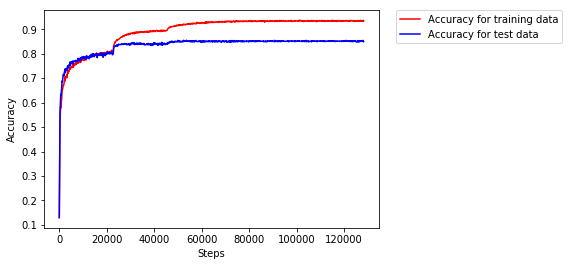

In [1]:
import matplotlib.pyplot as plt
import numpy as np

data_train = np.genfromtxt('train_graph.csv', delimiter = ',',names=['Time','Step','Train_Accuracy'])
data_eval = np.genfromtxt('eval_graph.csv',delimiter = ',',names=['Time','Step','Eval_Accuracy'])


plt.plot(data_train['Step'],data_train['Train_Accuracy'],'r',label="Accuracy for training data")
plt.plot(data_eval['Step'],data_eval['Eval_Accuracy'],'b',label="Accuracy for test data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.ylabel('Accuracy')
plt.xlabel('Steps')

plt.show()



### Deep Belief Networks

In the second phase of work, after some consideration and analysis about the behavior of GANs, we came to the conclusion that the fundamental architecture of the GAN is not suitable to our work. A GAN estimates the probability distribution of the dataset is it trained to *generate*. This was the insight that led us to focus on it. However, it produces estimates by repeatedly sampling the modelled distribuition in an ad-hoc manner. For the purposes of our work, it was required that presented a partial representation of a sample belonging to the (true) data distribution, the model use its estimate to reconstruct the sample. 

RBMs are building blocks for DBNs . RBMs make inference tractable by prohibiting connections between hidden units of the same layer leading to a factorial distribution, given an image, the state of a hidden unit is independent of other hidden units. An additional restriction is that fowrard and backward connections between layers are symmetric.

In essence, this model allows for an unsupervised method of learning by trying to model the joint probability p(v,h) =>  via the representational power of an RBM (in turn using a composition of RBMs that form a Deep Belief Network). Hinton et al put forward the idea of greedy layer wise learning for DBNs. The DBN can be sampled (using methods like Gibbs sampling) to model the data distribution (thus the DBN is a generative model). This is suitable for tasks such as image reconstruction.

#### Deep dive into RBMs

RBMs belong to a special class of probabilistic graphical models called *Markov Random Fields*. In this model, conditional dependence between random variables is denoted using a graph structure [13]. Each node in the graph can take a value that follows the distribution of the random variable associated with that node. This random variable is conditionally dependent only on nodes in its *neighbourhood*, known as the local Markov property (in space). An MRF can thus be thought to model the joint distribution of the random variables assigned to each node. In RBMs, the neurons are split into visible and hidden layers. Furthermore, connections between neurons belonging to the same layer are disallowed. With this, it can be concluded that given a sample on the visible layer of neurons, the value taken by each hidden neuron is independent of other hidden neurons (and vice vesa).

$$ p(\textbf{h}|\textbf{v}) = \prod_{i} p(h_i | \textbf{v}) $$


$$ p(\textbf{v}|\textbf{h}) = \prod_{j} p(v_j | \textbf{h}) $$

A *Markov Chain* can be constructed by looking at the evolution of the states of the nodes, with values drawn from the distributions followed by the random variables. In such a system, the next state of the system is only dependent on the current state. In an aperiodic and irreducible Markov Chain, after a finite number of transitions, a stationary distribution is reached i.e. the joint probability modelled by the graph converges. This logically leads to the key idea of why RBMs can be used as generative models. **If we want to generate data from some target distribution, it is possible to do so by construction a Markov chain with a stationary distribution which is equal to the target distribution.**

The stationary joint probability modelled by an MRF has the general form of:

$$ p(\textbf{x})  = 1/Z*exp(-E(\textbf{x}))$$


For an RBM, with split layers, the join probability can be written as,

$$ p(\textbf{v},\textbf{h})  = 1/Z*exp(-E(\textbf{v},\textbf{h}))$$


The stationary distribution for the visible layer is thus given by,

$$ p(\textbf{v})  = 1/Z*\sum_{\textbf{h}}exp(-E(\textbf{v},\textbf{h}))$$

** RBM Properties : **

An RBM wherein both the visible and hidden layer neurons can only take binary values is called a *Binary RBM*. The energy term is parametrized using connection weights between the visible and hidden layers (densely connected feedforward network) and is given in [13]. Using this parametrized energy term, the the conditional probabilities can be written as follows, (proof in [13])

$$ P(H_i = 1 | \textbf{v}) = sgm(\sum_{j=1}^{m} w_{ij}v_j + c_i)$$

$$ P(V_j = 1 | \textbf{h}) = sgm(\sum_{i=1}^{n} w_{ij}h_i + b_j)$$

Using appropriately trained parameters and a technique called *Gibbs sampling*, the RBM is used as a generative model. Gibbs sampling is a technique to produce samples from the stationary distribution of the MRF. Essentially, only a single node (picked randomly) is updated at a time. This technique is guaranteed to converge to the stationary distribution of the MRF (proof in [13]) starting from a random distribution. 

In RBMs, this becomes easier given the fact that nodes belonging to a layer are conditionally independent, thus Gibbs Sampling can be applied to an RBM by updating a layer at a time (instead of a node). Thus, starting from an incomplete sample from the data distribution as the initial distribution applied to the visible layer of the RBM, repeated Gibbs Sampling would eventually lead the MRF to the stationary distribution. By design, this distribution will be the target distribution to be generated. 


** Learning in RBMs: **

To create a generative model using RBMs, the energy term is parametrized and parameter values are adjusted in a way such that the stationary distribution at the visible layer is a good estimate of the distribution that the data to be generated is drawn from. This goal is achevied using *maximum likelihood estimation* which amounts to finding parameters that maximize the probability of the target data distribution being the stationary distribution of the MRF. The likelihood is optimzed in an iterative fashion using gradient descent. 

In a general MRF, the gradient of the likelihood w.r.t to the parameters is given by [14], 

$$E_{model}[\frac{\partial E(\textbf{v},\textbf{h})}{\partial \theta}] - E_{data}[\frac{\partial E(\textbf{v},\textbf{h})}{\partial \theta}]$$

Based on the expression for the energy in [13], it can be shown :

$$ \frac{\partial E(\textbf{v},\textbf{h})}{\partial w_{ij}} = h_iv_j $$

The expectation over the model needs the stationary distribution of the RBM to be known which typically is the learning objective (and thus not known during the course of learning), thus the gradient of the log-likelihood is approximated using a technique called *Constrastive Divergence*. In lieu of the stationary distribution, the expection over the stationary distribution can be approximated by considering finite number of steps of alternating Gibbs sampling i.e. *running* the Markov Chain for a finite number of steps. Thus, the approximation for the gradient becomes :

$$P(h_i = 1 | \textbf{v}^{(0)})v^{(0)}_j - P(h_i = 1 | \textbf{v}^{(k)})v^{(k)}_j$$


Each step of constrastive divergence involves sampling the values of the hidden layer using p(h|v) and using these sampled values generating values at the visible layer by sampling p(v|h). In the initial step of CD, the visible layer is initialized with a training example and this Gibbs chain is continued for k-steps in a k-step CD. The state of the RBM after these k-steps is used as an estimate for the stationary distribution of the model using which the second term of the gradient is approximated. Usually k=1 is sufficient for learning [13].





For generating real values at the visible layer, CD can be used where the generation step i.e. sampling the p(v|h) distribution is modified to sample from a Gaussian distribution with unit variance and mean, [15]

$$ b_j + \sum_{i=1}^{n} w_{ij}h_i$$ 

### Greedy Layer wise learning in Deep Belief Nets

A Deep Belief Net is essentially a stack of RBMs. Inspired from circuit theory, it is observed that deep architectures are much more efficient to create representations (w.r.t the number of parameters needed) as compared to shallow ones [16]. Hinton et al. have shown that addition of new layers improves the generative ability of the model [11]. The key idea for layer wise learning is to decompose the complex model into a set of simpler ones and learn parameters for each in a sequential manner. 

In this approach, the posterior over the first hidden layer is learnt by  (using CD) presenting the network with the training samples, with all the higher level weights *tied* i.e. not modified. The next hidden layer is then trained by presenting the training samples at the visible layer and using the learnt weights and posterior of the first hidden layer to learn the parameters for the second layer. This continues for all the layers of the DBN. While training a layer *l*, the learnt weights for layers *1* to *l-1* are not changed. Training each layer in this manner is called *unsupervised pre-training* [16]. 

Once each layer has been trained in this greedy fashion, the overall model is further fine-tuned w.r.t a training criterion (eg : MSE, Cross Entropy) using gradient descent to *fit* all the parameters. 

### Experiments

Certain experiments were performed by building upon a [pre-existing DBN implementation](https://github.com/albertbup/deep-belief-network). Hinton's initial approach to working with continuous valued data samples was used i.e. scaling the data to [0,1] range and using the probability of a binary neuron being 1 (given the sampled state of the hidden layer) as the value "held" by that neuron. A 2-layer DBN was used with a digits dataset part of the scikit-learn python package. The reconstruction error metric was computed as the squared error between the original and reconstructed image. 

Ideally, greedy layer-wise training must be followed by fine-tuning the weights of the entire DBN as whole using some training criterion (**discuss with Mike**). 

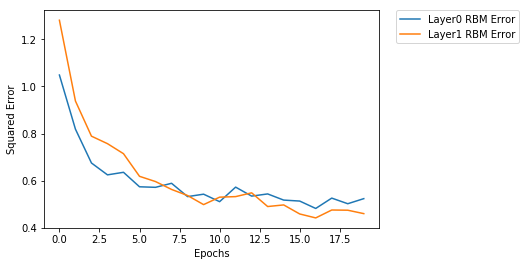

In [5]:
import pickle
import matplotlib.pyplot as plt

with open ('layer_0', 'rb') as fp:
    errorListLayer0 = pickle.load(fp)

with open ('layer_1', 'rb') as fp:
    errorListLayer1 = pickle.load(fp)


plt.plot(errorListLayer0,label='Layer0 RBM Error')
plt.ylabel('Squared Error')
plt.xlabel('Epochs')
plt.plot(errorListLayer1,label='Layer1 RBM Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

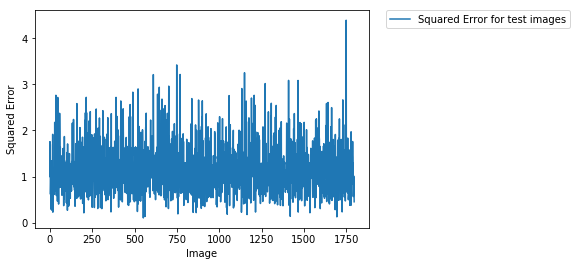

Average reconstruction error over test images : 1.134


In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open ('test_recon', 'rb') as fp:
    testRecon = pickle.load(fp)

plt.plot(testRecon,label='Squared Error for test images')
plt.ylabel('Squared Error')
plt.xlabel('Image')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

print('Average reconstruction error over test images : {0:.3f}'.format(np.mean(testRecon)))


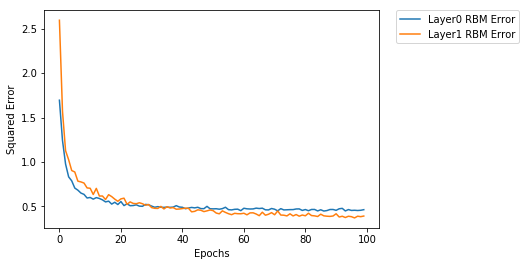

In [1]:
import pickle
import matplotlib.pyplot as plt

with open ('layer_0_100', 'rb') as fp:
    errorListLayer0 = pickle.load(fp)

with open ('layer_1_100', 'rb') as fp:
    errorListLayer1 = pickle.load(fp)


plt.plot(errorListLayer0,label='Layer0 RBM Error')
plt.ylabel('Squared Error')
plt.xlabel('Epochs')
plt.plot(errorListLayer1,label='Layer1 RBM Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

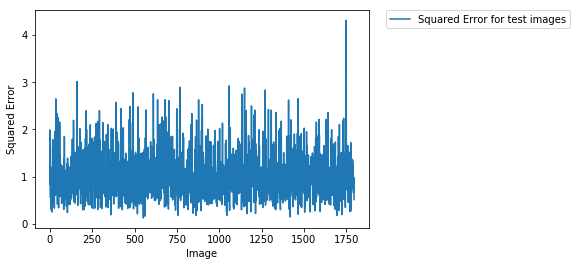

Average reconstruction error over test images : 1.011


In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open ('test_recon_100', 'rb') as fp:
    testRecon = pickle.load(fp)

plt.plot(testRecon,label='Squared Error for test images')
plt.ylabel('Squared Error')
plt.xlabel('Image')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 
plt.show()

print('Average reconstruction error over test images : {0:.3f}'.format(np.mean(testRecon)))


### Similarity Metric for Images

To gauge the effectiveness of the model reconstructing images, a metric to quantify the similarity between the original and the reconstructed image needs to be defined that in turn also quantifies the efficacy of the model. The RMS (root mean square) metric was considered, which is essentially the euclidean distance in the image space. This was deemed too strict since the model only seeks to estimate the distribution of the dataset. The RMS error would penalize a "good-enough" reconstruction disproportionately.

High-level image features such as SIFT, SURF and ORB were found suitable for the purpose of defining a similarity metric.  The code snippet below uses SIFT features/descriptors to compute the number of *matches* between 2 images. [FLANN based matching](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html#flann-based-matcher) is used to detect similar features in the 2 images. This uses a k-nearest neighbour approach by taking a feature (and it's descriptor) in one image and computing the number of similar features in the image it is being compared with. Good matches are specified by using [Lowe's metric](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) for similarity based on SIFT features.

SIFT and SURF both compute floating point descriptors and key-points. The SURF features extend the the SIFT features by using approximations in certain places to speed up computation. Compared to these, ORB features are binary, a direct consequence of this being, thhe hamming distance between binary features is used to compute matches. [The threshold for the distance is set to be 64.](https://stackoverflow.com/questions/22857398/matching-orb-features-with-a-threshold)

* **Self:**

Matches are computed with itself to as a control measure to estimate the number of *good* matches before calling a reconstruction a faithful one.

* **Slightly Blurred:**

Given the stocahstic nature of the model, the reconstructed image could be noisy. To get an estimate, we compute matches with a gaussian filtered (5x5 kernel) version of the reference image.

* **Very Blurred:**

A larger kernel (50x50) is chosen to get a worst case estimate.

* **Cropped:**

In the extreme case of failure to reconstruct, matches are computed for a (randomly) cropped partial image.

* **Translation:**

The case where the generated version is translated (in x and y direction) w.r.t the original image is considered 

**Correlation between the similarity metric and the process of generating images:** (*Discussion with Mike*)

The process of generating (extended to filling in missing data given partial images) images boils down to training the model with images sampled from a given distribution. Training comprises of adjusting the model parameters in a way such that the (parametrized) model distribution is as close as possible to the true data distribution. This is acheived by finding parameters such that the KL divergence between these distributions is minimum. Minimizing the KL divergence (or maximising the likelihood) is independent of the similarity metrics defined above. But it can be argued that if the model produces a good estimate of the data distribution i.e. it is sucessful in acheiving a low KL divergence at the end of training, the images generated by the model would have similar high-level features compared to the images the model was trained on thereby performing well on the similarity metrics. Thus, the defined metrics while not explicitly being a part of the training will be used to gauge the efficacy of training. 


Original Image 



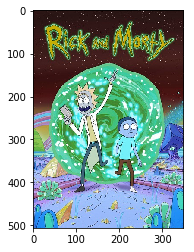

    Transformation    SIFT SURF ORB 
--------------------- ---- ---- ----
  5x5 Gaussian Filter 0.34  0.4 0.32
50x50 Gaussian Filter 0.01 0.03  0.0
          Random Crop 0.04 0.04 0.01
    Image Translation 0.62 0.58 0.63


In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from astropy.table import Table

# Function to compute matches between 2 images
def computeMatchesSIFT(img1,img2):
    # Create the ORB object
    sift = cv2.xfeatures2d.SIFT_create()
    
    sim_metric = 0
    
    # Keypoints and descriptors for the objects
    kp_ref, des_ref = sift.detectAndCompute(img1,None)
    kp_test, des_test = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des_ref,des_test,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            sim_metric = sim_metric + 1


    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    # Draw first 10 matches.
    img3 = cv2.drawMatchesKnn(img1,kp_ref,img2,kp_test,matches, None, **draw_params)
    
    #plt.imshow(img3),plt.show()
    return sim_metric

def computeMatchesSURF(img1,img2):
    surf = cv2.xfeatures2d.SURF_create(400)
    
    sim_metric = 0
    
    # Keypoints and descriptors for the objects
    kp_ref, des_ref = surf.detectAndCompute(img1,None)
    kp_test, des_test = surf.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des_ref,des_test,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            sim_metric = sim_metric + 1


    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    # Draw first 10 matches.
    img3 = cv2.drawMatchesKnn(img1,kp_ref,img2,kp_test,matches, None, **draw_params)
    
    #plt.imshow(img3),plt.show()
    
    return sim_metric

def computeMatchesORB(img1,img2):
    orb = cv2.ORB_create()
    sim_metric = 0
    
    # Keypoints and descriptors for the objects
    kp_ref, des_ref = orb.detectAndCompute(img1,None)
    kp_test, des_test = orb.detectAndCompute(img2,None)

    # Use Brute Force matcher + Hamming distance since binary features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    
    matches = bf.match(des_ref,des_test)

    # Need to draw only good matches, so create a mask
    goodMatches = []
    # ratio test as per Lowe's paper
    for i,m in enumerate(matches):
        # For threshold see: https://stackoverflow.com/questions/22857398/matching-orb-features-with-a-threshold
        if m.distance < 64:
            goodMatches.append(m)
            sim_metric = sim_metric + 1


    # Draw first 10 matches.
    img3 = cv2.drawMatches(img1,kp_ref,img2,kp_test,goodMatches,outImg=None,flags=2)
    
    #plt.imshow(img3),plt.show()
    
    return sim_metric



print('Original Image \n')
refImg = cv2.imread('image.jpg')
height,width = refImg.shape[:2]

plt.imshow(refImg),plt.show()
# Compute self matches
trueMatches = computeMatchesSIFT(refImg,refImg)
trueMatchesSURF = computeMatchesSURF(refImg,refImg)
trueMatchesORB = computeMatchesORB(refImg,refImg)

# Smoothen image
smoothImg = cv2.blur(refImg,(5,5))
smoothMatches = computeMatchesSIFT(refImg,smoothImg)
fracMatchesSmoothSIFT = float(smoothMatches)/float(trueMatches)

smoothMatches = computeMatchesSURF(refImg,smoothImg)
fracMatchesSmoothSURF = float(smoothMatches)/float(trueMatches)

smoothMatches = computeMatchesORB(refImg,smoothImg)
fracMatchesSmoothORB = float(smoothMatches)/float(trueMatches)



# More smoothening
smoothImg = cv2.blur(refImg,(50,50))

# Compute matches with smoothed image
smoothMatches = computeMatchesSIFT(refImg,smoothImg)
fracMatchesSmootherSIFT = float(smoothMatches)/float(trueMatches)

smoothMatches = computeMatchesSURF(refImg,smoothImg)
fracMatchesSmootherSURF = float(smoothMatches)/float(trueMatchesSURF)

smoothImg = cv2.resize(smoothImg,(width,height), interpolation = cv2.INTER_CUBIC)
smoothMatches = computeMatchesORB(smoothImg,refImg)
fracMatchesSmootherORB = float(smoothMatches)/float(trueMatchesORB)


# Cropping
cropImg = refImg[100:200,50:150]
cropMatches = computeMatchesSIFT(refImg,cropImg)
fracMatchesCropSIFT = float(cropMatches)/float(trueMatches)
cropMatches = computeMatchesSURF(refImg,cropImg)
fracMatchesCropSURF = float(cropMatches)/float(trueMatchesSURF)
cropMatches = computeMatchesORB(refImg,cropImg)
fracMatchesCropORB = float(cropMatches)/float(trueMatchesORB)


#Translating the image
xShift = 100
yShift = 100
rows,cols,channels = refImg.shape
shiftMatrix = np.float32([[1,0,xShift],[0,1,yShift]])
shiftImg = cv2.warpAffine(refImg,shiftMatrix,(cols,rows))
shiftMatches = computeMatchesSIFT(refImg,shiftImg)
fracMatchesTransSIFT = float(shiftMatches)/float(trueMatches)
shiftMatches = computeMatchesSURF(refImg,shiftImg)
fracMatchesTransSURF = float(shiftMatches)/float(trueMatchesSURF)
shiftMatches = computeMatchesORB(refImg,shiftImg)
fracMatchesTransORB = float(shiftMatches)/float(trueMatchesORB)


data_matrix = np.array([('5x5 Gaussian Filter',round(fracMatchesSmoothSIFT,2),round(fracMatchesSmoothSURF,2),round(fracMatchesSmoothORB,2)),
                        ('50x50 Gaussian Filter',round(fracMatchesSmootherSIFT,2),round(fracMatchesSmootherSURF,2),round(fracMatchesSmootherORB,2)),
                        ('Random Crop',round(fracMatchesCropSIFT,2),round(fracMatchesCropSURF,2),round(fracMatchesCropORB,2)),
                        ('Image Translation',round(fracMatchesTransSIFT,2),round(fracMatchesTransSURF,2),round(fracMatchesTransORB,2))])

table = Table(data_matrix,names = ('Transformation','SIFT','SURF','ORB'))
print(table)






### References:

1. [Stanford C231 course](http://cs231n.github.io/)
2. [Overview of optimization stategies](http://ruder.io/optimizing-gradient-descent/)
3. [Introduction to Bayesian Statistics](http://www.patricklam.org/uploads/3/8/2/6/3826399/bayesianhour_print.pdf)
4. [Deep dive into backpropagation](http://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/)
5. [Dropout by Srivastava et al.](http://jmlr.org/papers/v15/srivastava14a.html)
6. [Batch Normalization](http://arxiv.org/abs/1502.03167)
7. [Image Net 2012 winning paper](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
8. [Fundamentals of Deep Belief Networks](http://dx.doi.org/10.1162/neco.2008.04-07-510)
9. [OpenCV Feature matching](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)
10. [SIFT features](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)
11. [Hinton et al. , "A Fast Training Algorithm For Deep Belief Nets"](http://www.mitpressjournals.org/doi/pdf/10.1162/neco.2006.18.7.1527)
12. [Hinton, "Practical Guide to traning Restricted Boltzmann Machines"](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
13. [Fischer et al., Training Restricted Boltzmann Machines : An Introduction](https://doi.org/10.1016/j.patcog.2013.05.025)
14. [Tang et al., Robust Boltzmann Machines](https://www.cs.cmu.edu/~rsalakhu/papers/robm.pdf)
15. [Hinton et al., Reducing Data Dimensionality Using Neural Networks](http://science.sciencemag.org/content/313/5786/504)
16. [Bengio et al., Greedy Layer-Wise Training of Deep Networks](http://www.iro.umontreal.ca/~lisa/pointeurs/BengioNips2006All.pdf)